# iCAT world
---

#### Overview
Notebook to create stacks of tile specifications in "real-world" or "physical" coordinate space (aka microns). This is to facilitate `5_iCAT-correlate.ipynb` as there is otherwise no way of knowing _a priori_ which high-mag EM tiles overlap with each low-mag EM tile.

#### Packages

In [17]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import renderapi
import icatapi

#### Settings

In [18]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up environment
---

In [19]:
# `render` project parameters
# ---------------------------
owner = 'skaracoban'
project = '20240219_PD05_final_test'

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'http://localhost',
    'port': 8081,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://localhost',
 'port': 8081,
 'owner': 'skaracoban',
 'project': '20240219_PD05_final_test',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [20]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]

# Output
# ------
out = f"""\
all stacks.......... {stacks}
EM stacks........... {stacks_EM}
FM stacks........... {stacks_FM}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
stacks = ['EM_lomag', 'EM_himag']
df_project = icatapi.create_stacks_DataFrame(stacks=stacks,
                                             render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))

all stacks.......... ['EM_lomag_overlaid', 'exc_405nm_overlaid', 'EM_himag_stitched', 'EM_himag_montaged', 'exc_405nm', 'EM_lomag', 'EM_himag']
EM stacks........... ['EM_lomag_overlaid', 'EM_himag_stitched', 'EM_himag_montaged', 'EM_lomag', 'EM_himag']
FM stacks........... ['exc_405nm_overlaid', 'exc_405nm']
...



/tmp/ipykernel_1500438/1607255090.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(3))


tileId    z   width  height   minint   maxint  \
stack                                                                
EM_himag 60  abz_EM_hima...  0.0  4096.0  4096.0  32348.0  37075.0   
         57  abw_EM_hima...  0.0  4096.0  4096.0  32348.0  37075.0   
         66  acf_EM_hima...  0.0  4096.0  4096.0  32348.0  37075.0   
EM_lomag 1   aab_EM_loma...  0.0  4096.0  4096.0  33394.0  37056.0   
         5   aaf_EM_loma...  0.0  4096.0  4096.0  33394.0  37056.0   
         4   aae_EM_loma...  0.0  4096.0  4096.0  33394.0  37056.0   

               imagePyramid          tforms     stack sectionId  imageRow  \
stack                                                                       
EM_himag 60  [0, 1, 2, 3...  [M=[[1.0000...  EM_himag      S001         1   
         57  [0, 1, 2, 3...  [M=[[1.0000...  EM_himag      S001         1   
         66  [0, 1, 2, 3...  [M=[[1.0000...  EM_himag      S001         0   
EM_lomag 1   [0, 1, 2, 3...  [M=[[1.0000...  EM_lomag      S001         2   
         5   [0, 1, 2, 3...  [M=[[1.0000...  EM_lomag      S001         1   
         4   [0, 1, 2, 3...  [M=[[1.0000...  EM_lomag      S001         1   

             imageCol   stageX    stageY  
stack                                     
EM_himag 60         3  635.920 -2578.932  
         57         0  604.816 -2578.929  
         66         6  667.012 -2568.419  
EM_lomag 1          1  740.264 -2881.588  
         5          2  918.972 -2700.333  
         4          1  740.259 -2700.292

## Create world stacks
---

In [21]:
from matplotlib.transforms import Affine2D as AffineMPL
from renderapi.transform import AffineModel as AffineRender

from icatapi.overlay import get_transform_metadata

In [22]:
channel_map = {
    'EM_lomag': 'Secondary electrons',
    'EM_himag': 'Secondary electrons'
}

# Loop through stacks
for stack, df_stack in tqdm(df_project.groupby('stack')):

    # Loop through tiles
    for i, tile in df_stack.iterrows():

        # Get transform metadata
        fp = Path(tile['imagePyramid'][0].imageUrl.split('.nl')[1])
        tform_md = get_transform_metadata(fp)
        channel_name = channel_map[stack]
        pixelsize, rotation, shear, translation = tform_md[channel_name]

        # Convert from metres to microns
        pixelsize = [1e6*ps for ps in pixelsize]      # m --> um
        translation = [1e6*tr for tr in translation]  # m --> um

        # Create transform
        w = tile['width']
        h = tile['height']
        T = AffineMPL().translate(-w/2, -h/2)\
                       .scale(*pixelsize)\
                       .rotate(rotation)\
                       .skew(shear, 0)\
                       .translate( translation[0],
                                  -translation[1])
        A = AffineRender()
        A.M = T.get_matrix()

        # Replace transform in DataFrame
        df_stack.at[i, 'tforms'] = [A]

    # Create world stack
    stack_world = f"{stack}_world"
    stacks += [stack_world]
    print(stack_world)
    icatapi.upload_stack_DataFrame(df=df_stack,
                                   name=stack_world,
                                   render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/skaracoban/render_code/iCAT-workflow/icatapi/overlay.py:35: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  metadata = Soup(xml_data, 'lxml')


EM_himag_world
Creating tile specifications for EM_himag_world...
Importing tile specifications to EM_himag_world...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240219_PD05_final_test --stack EM_himag_world /tmp/tmpjvuzfeym.json


15:42:30.160 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
15:42:30.367 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240219_PD05_final_test"
  },
  "tileSpecValidator" : { },
  "stack" : "EM_himag_world",
  "tileFiles" : [
    "/tmp/tmpj

## Inspect stacks
---

In [23]:
from icatapi.plotting import plot_tile_map, plot_stacks

### Map out tiles in `render` space

  0%|          | 0/1 [00:00<?, ?it/s]

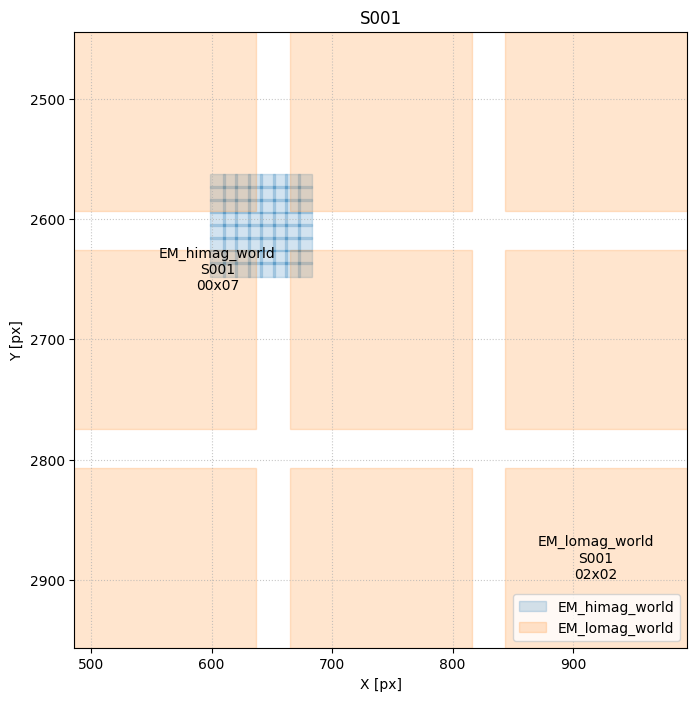

In [24]:
# Set stacks to plot
stacks_2_plot = [stack for stack in stacks if 'world' in stack]

# Plot tile map
plot_tile_map(stacks_2_plot, render=render)